In [1]:
import cv2

In [2]:
cap = cv2.VideoCapture('/beegfs/ua349/mlb/GOPR0095 - pitch 11.mp4')
frames = []
stat, img = cap.read()
while img is not None:
    frames.append(img)
    stat, img = cap.read()
assert len(frames) != 0

In [3]:
print(len(frames), frames[0].shape)

273 (1080, 1920, 3)


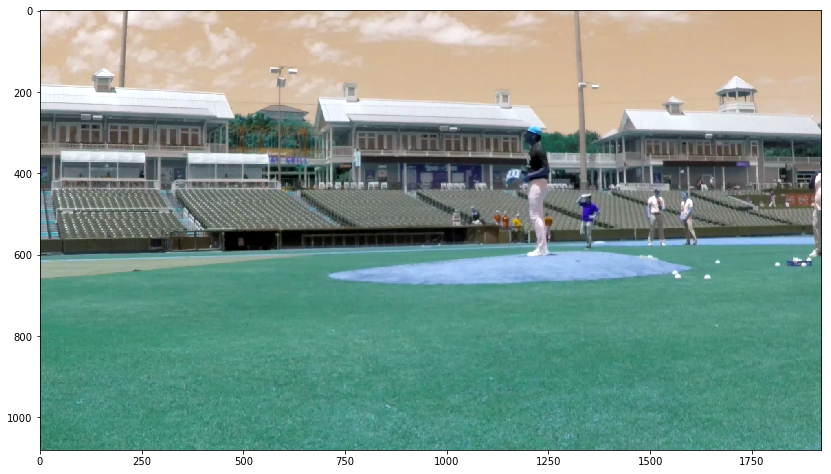

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
plt.imshow(frames[0])
plt.show()

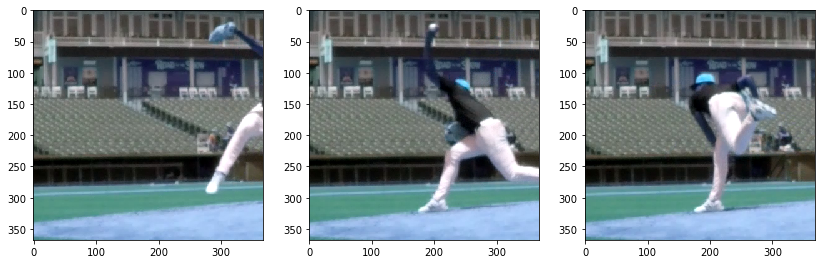

In [5]:
inpsize = int(368 * 1)

plt.figure(figsize=(14, 10))
plt.subplot(1, 3, 1)
plt.imshow(frames[-75][300:300+inpsize, 750:750+inpsize])
plt.subplot(1, 3, 2)
plt.imshow(frames[-50][300:300+inpsize, 750:750+inpsize])
plt.subplot(1, 3, 3)
plt.imshow(frames[-25][300:300+inpsize, 750:750+inpsize])
plt.show()

In [6]:
from models import mod_v1 as Model

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
model = Model(time_steps=4)

In [8]:
# model.load_weights('checkpoints/video-epoch_0.h5')
model.load_weights('checkpoints/video-epoch_0.h5')

In [9]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 4, 368, 368, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 4, 46, 46, 19) dtype=float32>]
[<tf.Tensor 'weight_stage1_L2/mul:0' shape=(?, 4, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage2_L2/mul:0' shape=(?, 4, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage3_L2/mul:0' shape=(?, 4, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage4_L2/mul:0' shape=(?, 4, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage5_L2/mul:0' shape=(?, 4, 46, 46, 19) dtype=float32>, <tf.Tensor 'weight_stage6_L2/mul:0' shape=(?, 4, 46, 46, 19) dtype=float32>]


In [42]:
import numpy as np
sized = []
for ii in range(-25, -10, 1):
    img = frames[ii][300:300+inpsize, 750:750+inpsize]
    img = cv2.resize(img, (0,0), fx=368/inpsize, fy=368/inpsize)
    sized.append(img)
sized = np.array(sized)
print(sized.shape)
sized = sized.reshape(15, 368, 368, 3)

(15, 368, 368, 3)


In [56]:
heat_avg = np.zeros((len(sized), 46, 46, 19))

mask = np.ones((1, 4, 46, 46, 19))
# mask[:, :, :, 12:25, :] = 1

for ii in range(4, len(sized)):
    seq = sized[ii-4:ii]
    
    results = model.predict([
        np.array([seq]),
        mask
    ])
    
    last_heat = results[-1][0]
#     heat_avg[ii-4:ii] += last_heat
    heat_avg[ii-4:ii] = last_heat


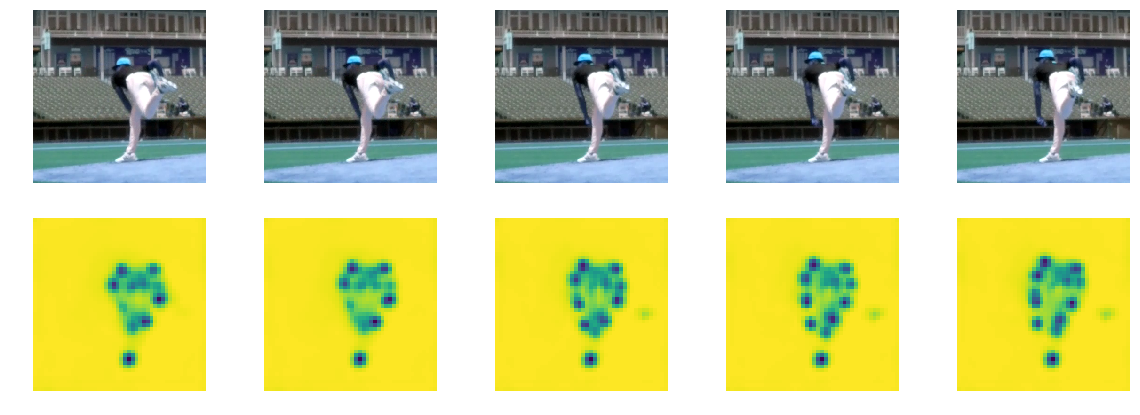

In [57]:
import matplotlib.pyplot as plt
start = 0
num = 5

plt.figure(figsize=(20, 7))
for ii in range(num):
    plt.subplot(2, num, ii+1)
    plt.axis('off')
    plt.imshow(sized[start + ii])
for ii in range(num):
    plt.subplot(2, num, num+ii+1)
    plt.axis('off')
    plt.imshow(heat_avg[start + ii, :, :, -1])
plt.show()

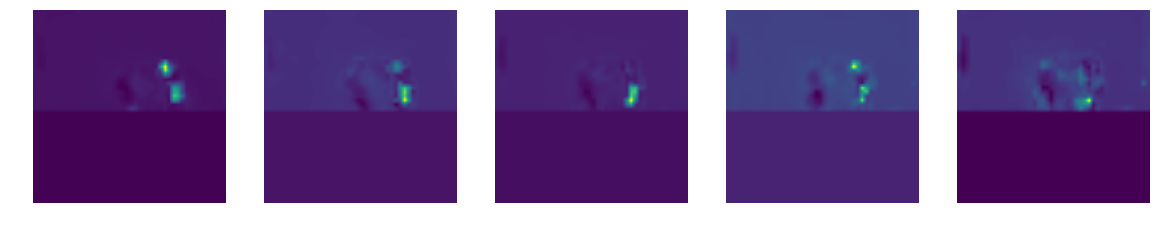

In [58]:
plt.figure(figsize=(20, 7))

vmask = np.zeros((46, 46))
vmask[:24, :] = 1
for ii in range(num):
    plt.subplot(1, num, ii+1)
    plt.axis('off')
#     plt.imshow(sized[start + ii])
    ankle = heat_avg[start + ii, :, :, 13]
    ankle = np.multiply(ankle, vmask)
    bigheat = cv2.resize(ankle, (0,0), fx=8, fy=8)
#     plt.imshow(sized[start + ii])
    plt.imshow(bigheat)
plt.show()

In [49]:
import os, sys
sys.path.append('../tf/ver1')
from model.cmu_model import get_testing_model

targ = get_testing_model()

In [50]:
targ.load_weights('../tf/ver1/model/keras/model.h5')

In [51]:
targ_heats = []
for ii in range(num):
    outs = targ.predict(sized[start + ii:start + ii+1])
    last_heat = outs[-1]
    assert last_heat.shape[-1] == 19
    targ_heats.append(last_heat)

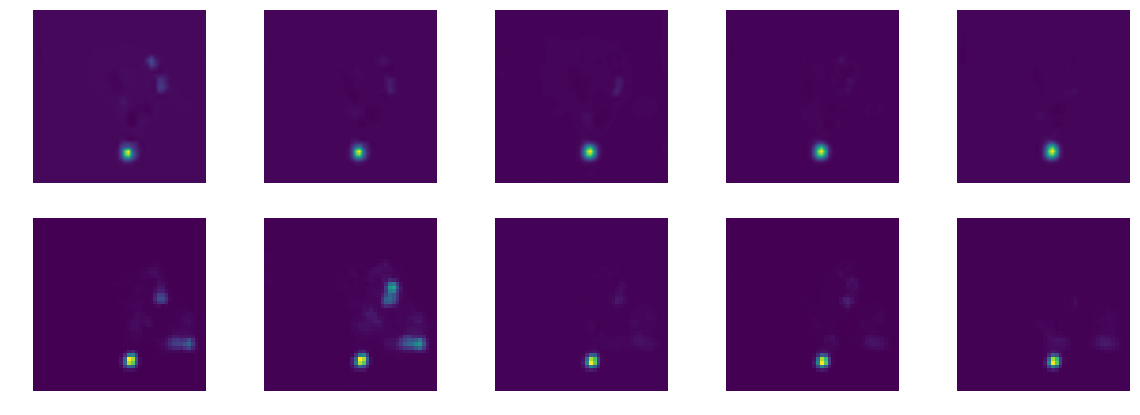

In [59]:
plt.figure(figsize=(20, 7))
for ii in range(num):
    plt.subplot(2, num, ii+1)
    plt.axis('off')
    ankle = heat_avg[start + ii, :, :, 13]
#     ankle = np.multiply(ankle, vmask)
    bigheat = cv2.resize(ankle, (0,0), fx=8, fy=8)
    plt.imshow(bigheat)
    
    plt.subplot(2, num, num+ii+1)
    plt.axis('off')
    plt.imshow(targ_heats[ii][0, :, :, 13])
plt.show()

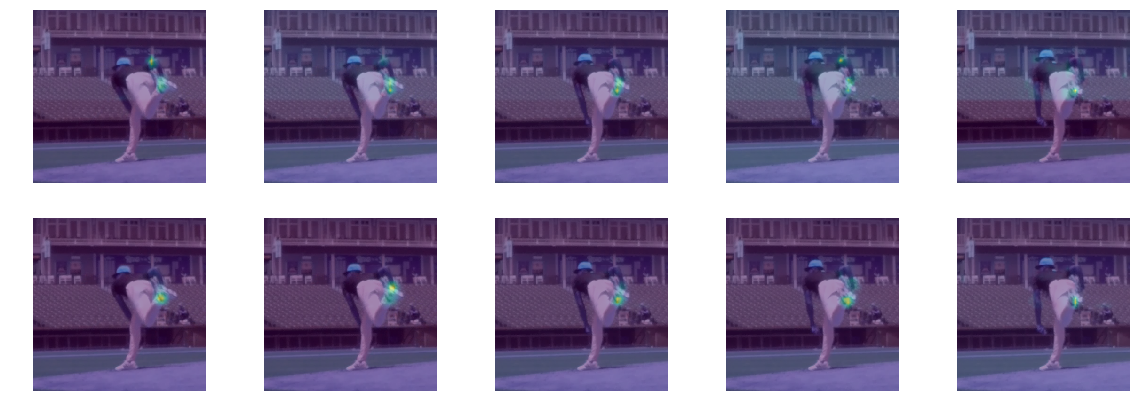

In [60]:
plt.figure(figsize=(20, 7))

vmask = np.zeros((46, 46))
vmask[:24, :] = 1


for ii in range(num):
#     smallim = cv2.resize(sized[start + ii], (0,0), fx=1/8, fy=1/8)
    plt.subplot(2, num, ii+1)
    plt.axis('off')
    ankle = heat_avg[start + ii, :, :, 13]
    ankle = np.multiply(ankle, vmask)
    ankle = cv2.resize(ankle, (0,0), fx=8, fy=8)
    plt.imshow(ankle/4)
    plt.imshow(sized[start + ii], alpha=0.5)
    
    plt.subplot(2, num, num+ii+1)
    plt.axis('off')
    targ = targ_heats[ii][0, :, :, 13]
    targ = np.multiply(targ, vmask)
    targ = cv2.resize(targ, (0,0), fx=8, fy=8)
    plt.imshow(targ)
    plt.imshow(sized[start + ii], alpha=0.5)
plt.show()

## Things to tweak

* Frame interval - adjust amount of motion between frames
* Input heatmap from previous inference
* Video-long training instead of discrete seq training

Carry over heatmap outputs of previous sequences

* Only grade output frame of sequence